In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

# Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialise GPU

In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading and Pre-processing

In [4]:
# Class for pre-processing the data
class MIMICDataProcessor:
    def __init__(self, file_path, batch_size=64):
        self.file_path = file_path
        self.batch_size = batch_size
        self.scaler = StandardScaler()

        # Load and preprocess the data
        self.df = pd.read_csv(file_path)
        # Replace all missing values with 0
        self.df.fillna(0, inplace=True)

        # Features
        self.X = self.df[['aniongap_max', 'albumin_max', 'albumin_min', 'rsp_pao2fio2_vent_min', 'rsp_pao2fio2_novent_min',
                          'cgn_platelet_min', 'lvr_bilirubin_max', 'cdv_mbp_min', 'cdv_rate_dopamine', 'cdv_rate_dobutamine',
                          'cdv_rate_epinephrine', 'cdv_rate_norepinephrine', 'gcs_min', 'rfl_urineoutput', 'rfl_creatinine_max']]

        # Concepts
        self.C = self.df[['rsp_fail_moderate', 'rsp_fail_severe', 'cgn_fail_moderate', 'cgn_fail_severe', 'lvr_fail_moderate',
                          'lvr_fail_severe', 'cdv_fail_moderate', 'cdv_fail_severe', 'gcs_fail_moderate', 'gcs_fail_severe',
                          'rfl_fail_moderate', 'rfl_fail_severe', 'SSH', 'ARD', 'HES', 'COD', 'MOD', 'CRF', 'LCF',
                          'flag_high_aniongap', 'flag_low_albumin', 'flag_high_albumin', 'flag_high_bilirubin']]

        # Label
        self.Y = self.df['mortality_year']

        # Convert to tensors
        self.X_tensor = torch.tensor(self.X.values, dtype=torch.float32)
        self.C_tensor = torch.tensor(self.C.values, dtype=torch.float32)
        self.Y_tensor = torch.tensor(self.Y.values, dtype=torch.float32)

        # Normalize the features
        self.X_scaled = self.scaler.fit_transform(self.X)
        self.X_tensor_scaled = torch.tensor(self.X_scaled, dtype=torch.float32)

    def get_features(self):
        return self.X.columns.tolist()

    def get_concepts(self):
        return self.C.columns.tolist()

    def get_labels(self):
        return self.Y.columns.tolist()

    # Dataset class needed to provide the __getitem__ method for DataLoader
    class MIMICDataset(Dataset):
        def __init__(self, x, c, y):
            self.x = x
            self.c = c
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.x[idx], self.c[idx], self.y[idx]

    def create_dataloaders(self):
        # Split the data into temporary (80%) and test (20%) sets
        X_temp, X_test, C_temp, C_test, Y_temp, Y_test = train_test_split(
            self.X_tensor_scaled, self.C_tensor, self.Y_tensor, test_size=0.20, random_state=42)

        # Further split the temporary data into training (75% of temporary) and validation (25% of temporary) sets
        X_train, X_val, C_train, C_val, Y_train, Y_val = train_test_split(
            X_temp, C_temp, Y_temp, test_size=0.25, random_state=42)

        train_dataset = self.MIMICDataset(X_train, C_train, Y_train)
        val_dataset = self.MIMICDataset(X_val, C_val, Y_val)
        test_dataset = self.MIMICDataset(X_test, C_test, Y_test)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

# Model

In [5]:
class MultiLabelNN(nn.Module):
    def __init__(self, num_features, num_concepts, num_labels):
        super(MultiLabelNN, self).__init__()
        # Layers to predict concepts
        self.layer1 = nn.Linear(num_features, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 64)
        self.concept_output_layer = nn.Linear(64, num_concepts)

        # Layers to predict final output from concepts
        self.layer5 = nn.Linear(num_concepts, 64)
        self.layer6 = nn.Linear(64, 128)
        self.layer7 = nn.Linear(128, 64)
        self.label_output_layer = nn.Linear(64, num_labels)


    def forward(self, x):
        # Layers for concept prediction
        x_c = torch.relu(self.layer1(x))
        x_c = torch.relu(self.layer2(x_c))
        x_c = torch.relu(self.layer3(x_c))
        intermediate_output = self.concept_output_layer(x_c)
        intermediate_probability = torch.sigmoid(intermediate_output)

        # Layers for label prediction
        x = torch.relu(intermediate_output)
        x = torch.relu(self.layer5(x))
        x = torch.relu(self.layer6(x))
        x = torch.relu(self.layer7(x))
        final_probability = torch.sigmoid(self.label_output_layer(x))

        return intermediate_probability, final_probability

# Training

Look at the Step 5 from this [basic code](https://colab.research.google.com/drive/1LqE89tPVt6h1wa7lerLgF4GNvRw9QFDw?usp=sharing) for reference.

In [6]:
def train(x_size, c_size, y_size, x_to_y_learning_rate, lamda, epochs, train_loader, val_loader):
    torch.manual_seed(25)

    x_to_y = MultiLabelNN(num_features=x_size, num_concepts=c_size, num_labels=y_size).to(device)

    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification
    x_to_y_optimizer = torch.optim.Adam(x_to_y.parameters(), lr=x_to_y_learning_rate)

    epochs_count = []
    x_to_c_loss_values, c_to_y_loss_values, total_loss_values = [], [], []
    x_to_c_predictions, c_to_y_predictions = [], []
    x_to_c_val_loss_values, c_to_y_val_loss_values, total_val_loss_values = [], [], []
    x_to_c_val_predictions, c_to_y_val_predictions = [], []
    ground_truth_val_c, ground_truth_val_y = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        x_to_y.train()

        running_x_to_c_loss, running_c_to_y_loss = 0.0, 0.0
        running_total_loss = 0.0
        total_samples = 0

        for i, batch in enumerate(train_loader):
            x, c, y = batch
            x, c, y = x.to(device), c.to(device), y.to(device)

            # Forward pass through x_to_y
            x_to_y_optimizer.zero_grad()
            x = x.to(x_to_y.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
            predicted_c, predicted_y = x_to_y(x)

            # Squeeze the predictions to match the target dimensions
            predicted_c = predicted_c.squeeze()
            predicted_y = predicted_y.squeeze()

            x_to_c_predictions.append(predicted_c.detach().cpu().numpy())
            c_to_y_predictions.append(predicted_y.detach().cpu().numpy())

            c_loss = criterion(predicted_c, c.float())
            y_loss = criterion(predicted_y, y.float())

            # Combined loss
            total_loss = c_loss + lamda * y_loss

            # Backward pass and optimisation for combined loss
            total_loss.backward()
            x_to_y_optimizer.step()

            # Accumulate loss values
            running_x_to_c_loss += c_loss.item()
            running_c_to_y_loss += y_loss.item()
            running_total_loss += total_loss.item()

            total_samples += len(y)

        x_to_c_loss_values.append(running_x_to_c_loss / len(train_loader))
        c_to_y_loss_values.append(running_c_to_y_loss / len(train_loader))
        total_loss_values.append(running_total_loss / len(train_loader))

        # valing Loop
        x_to_y.eval()

        running_x_to_c_val_loss, running_c_to_y_val_loss = 0.0, 0.0
        running_total_val_loss = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for x, c, y in val_loader:
                # GPU
                x, c, y = x.to(device), c.to(device), y.to(device)

                # Ground truth array
                ground_truth_val_c.append(c.cpu())
                ground_truth_val_y.append(y.cpu())

                # Forward pass through x_to_y
                x = x.to(x_to_y.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
                predicted_c, predicted_y = x_to_y(x)

                # Squeeze the predictions to match the target dimensions
                predicted_c = predicted_c.squeeze()
                predicted_y = predicted_y.squeeze()

                x_to_c_val_predictions.append(predicted_c.detach().cpu().numpy())
                c_to_y_val_predictions.append(predicted_y.detach().cpu().numpy())

                c_loss = criterion(predicted_c, c.float())
                y_loss = criterion(predicted_y, y.float())

                total_loss = c_loss + lamda * y_loss

                # Accumulate loss values for valing
                running_x_to_c_val_loss += c_loss.item()
                running_c_to_y_val_loss += y_loss.item()
                running_total_val_loss += total_loss.item()

                total_val_samples += len(y)

        x_to_c_val_loss_values.append(running_x_to_c_val_loss / len(val_loader))
        c_to_y_val_loss_values.append(running_c_to_y_val_loss / len(val_loader))
        total_val_loss_values.append(running_total_val_loss / len(train_loader))

    return (x_to_y, epochs_count, x_to_c_loss_values, c_to_y_loss_values, total_loss_values, x_to_c_predictions, c_to_y_predictions, x_to_c_val_loss_values, c_to_y_val_loss_values, total_val_loss_values, x_to_c_val_predictions, c_to_y_val_predictions, ground_truth_val_c, ground_truth_val_y)

In [7]:
# Specify Parameters
x_size = 15
c_size = 23
y_size = 1
x_to_y_learning_rate = 0.01
lamda = 0.3
epochs = 60

# Load Data
file_path = '/content/cohorta_trial1_data.csv'
data_processor = MIMICDataProcessor(file_path, batch_size=64)
train_loader, test_loader, val_loader = data_processor.create_dataloaders()

x_to_y, epochs_count, x_to_c_loss_values, c_to_y_loss_values, total_loss_values, x_to_c_predictions, c_to_y_predictions, x_to_c_val_loss_values, c_to_y_val_loss_values, total_val_loss_values, x_to_c_val_predictions, c_to_y_val_predictions, ground_truth_val_c, ground_truth_val_y = train(x_size, c_size, y_size, x_to_y_learning_rate, lamda, epochs, train_loader, val_loader)

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


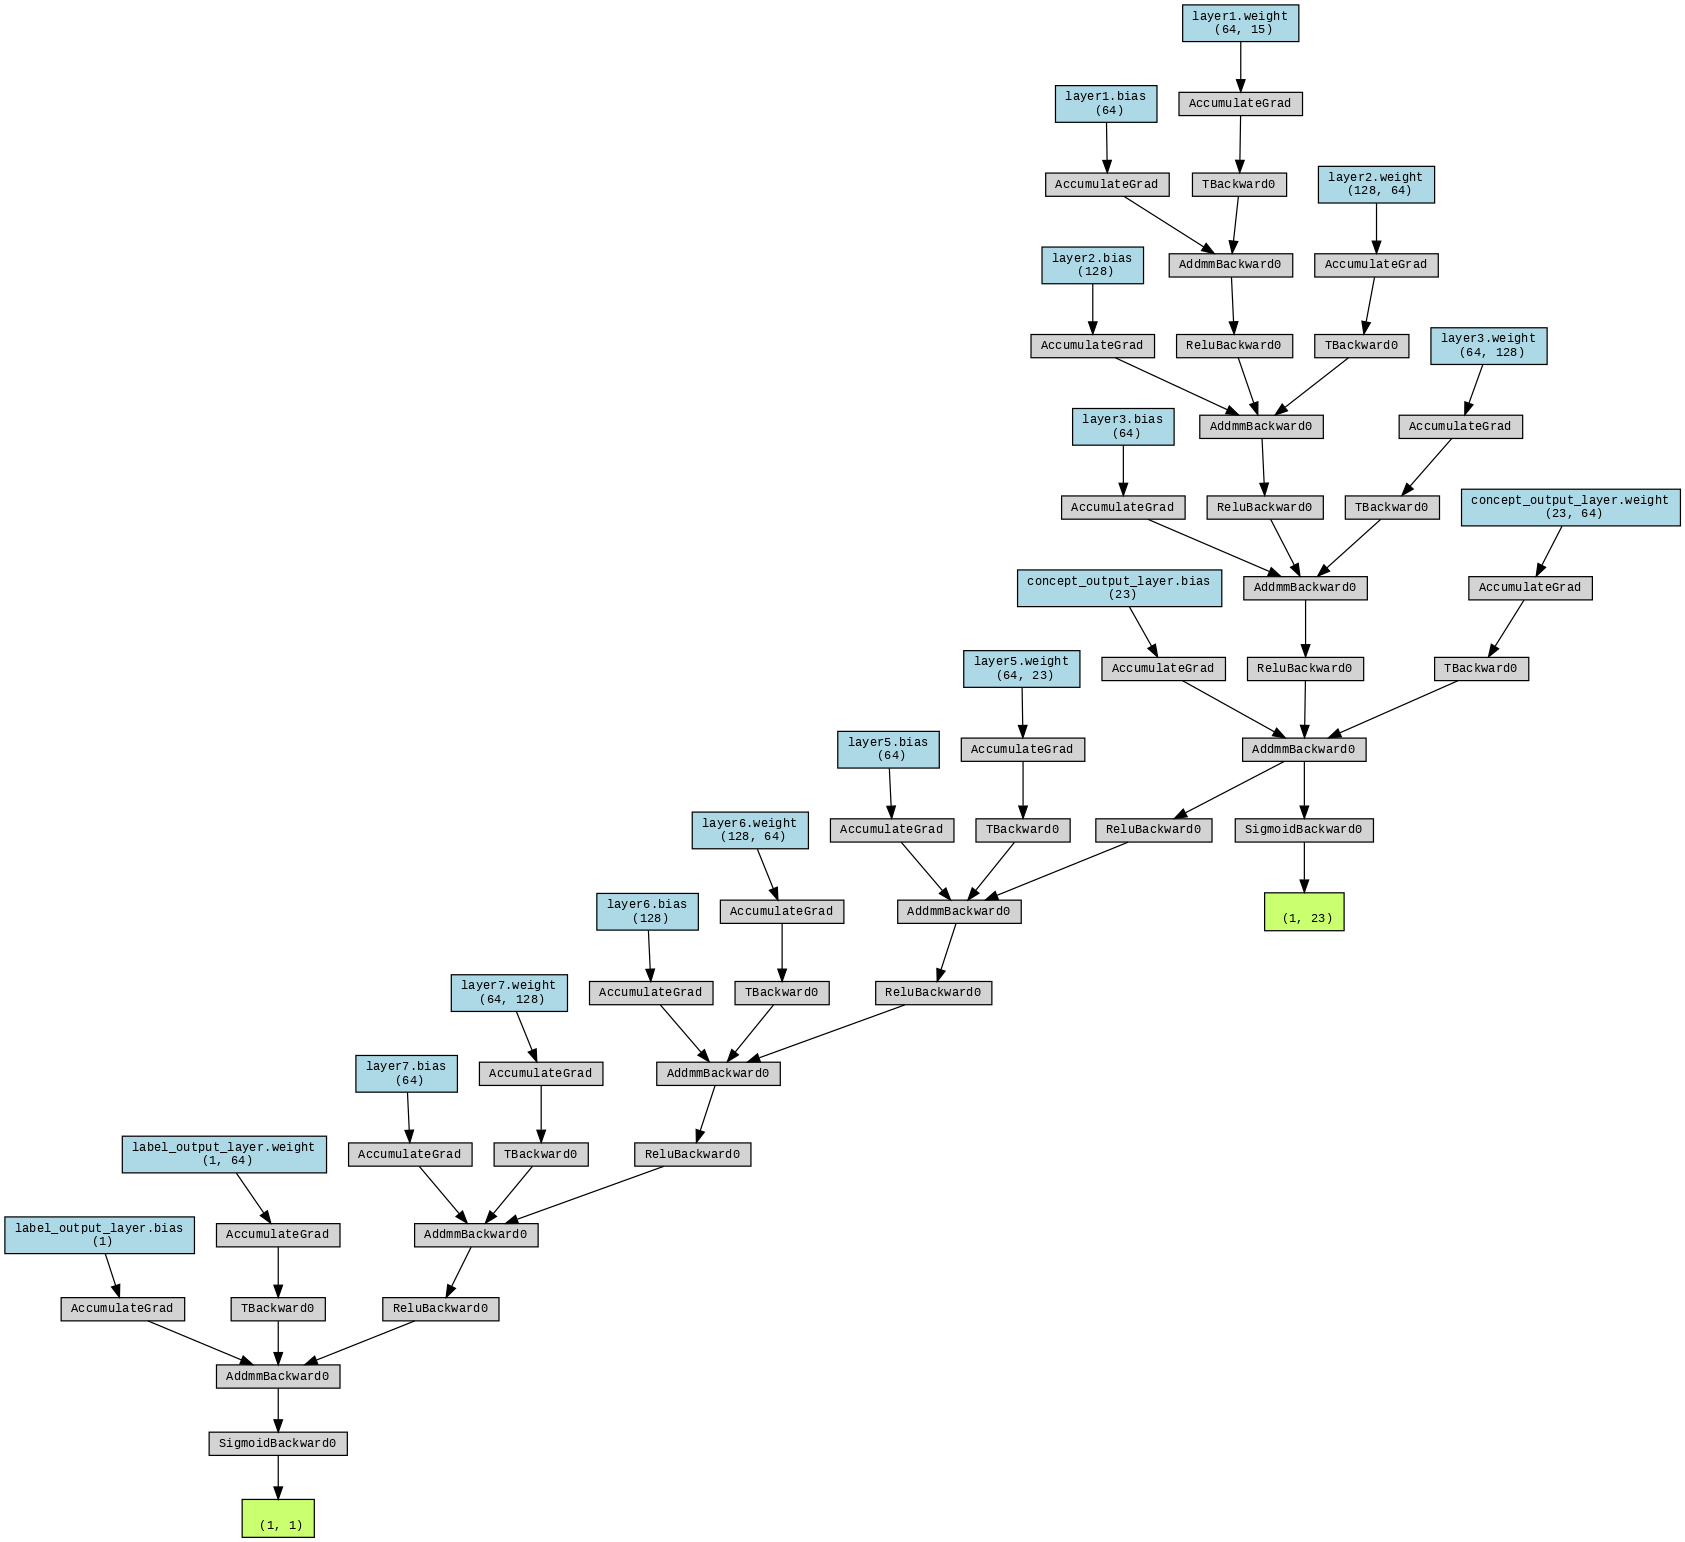

In [8]:
from torchviz import make_dot

# Instantiate the model
model = MultiLabelNN(num_features=x_size, num_concepts=c_size, num_labels=y_size).to(device)

# Create a dummy input tensor with the appropriate size
dummy_input = torch.randn(1, x_size).to(device)

# Pass the dummy input through the model to get the intermediate and final output
intermediate_output, final_output = model(dummy_input)

# Visualize the model
dot = make_dot((intermediate_output, final_output), params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('multi_label_nn_visualization')

# Display the visualization
from IPython.display import Image
Image(filename='multi_label_nn_visualization.png')

# Plotting Loss

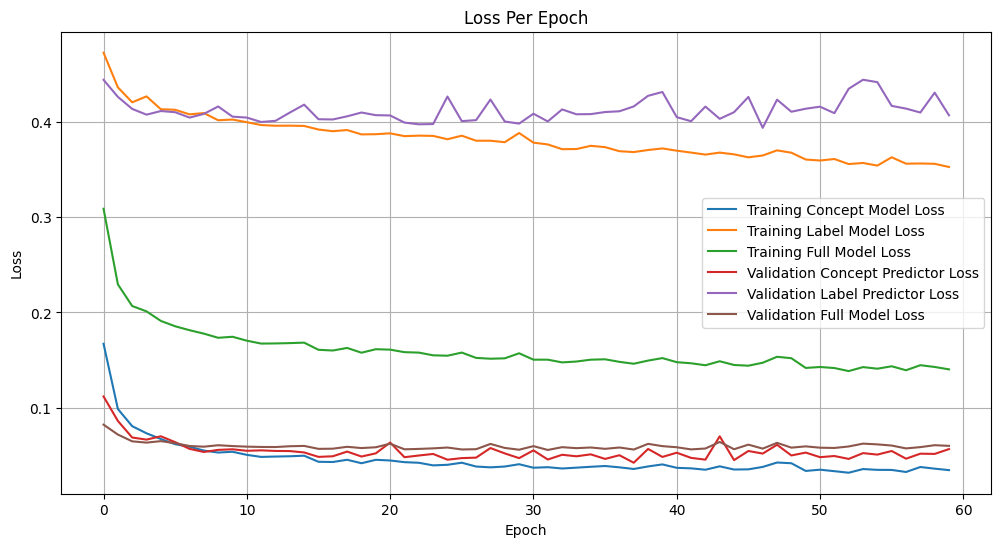

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Training Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Training Label Model Loss')
plt.plot(epochs_count, total_loss_values, label='Training Full Model Loss')
plt.plot(epochs_count, x_to_c_val_loss_values, label='Validation Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_val_loss_values, label='Validation Label Predictor Loss')
plt.plot(epochs_count, total_val_loss_values, label='Validation Full Model Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

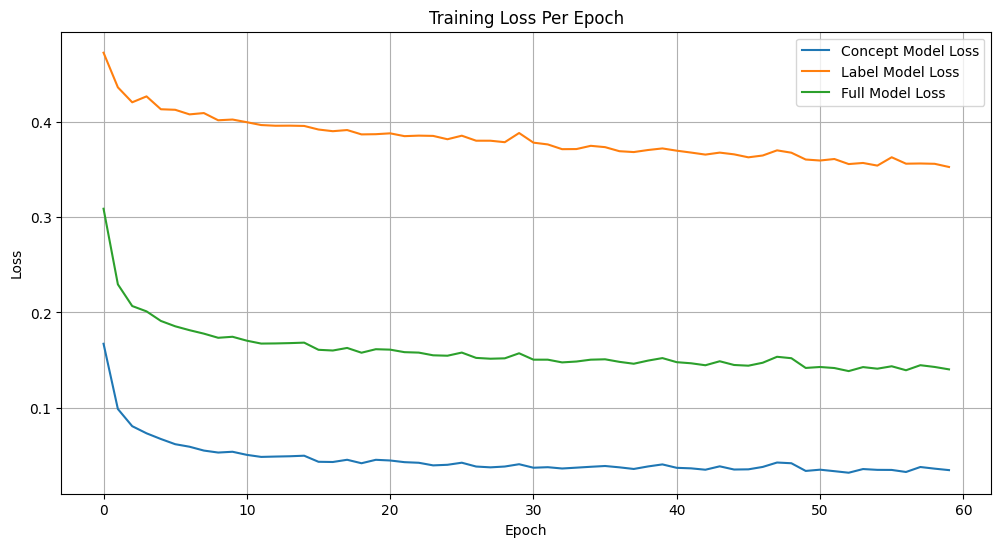

In [10]:
# Training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Label Model Loss')
plt.plot(epochs_count, total_loss_values, label='Full Model Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

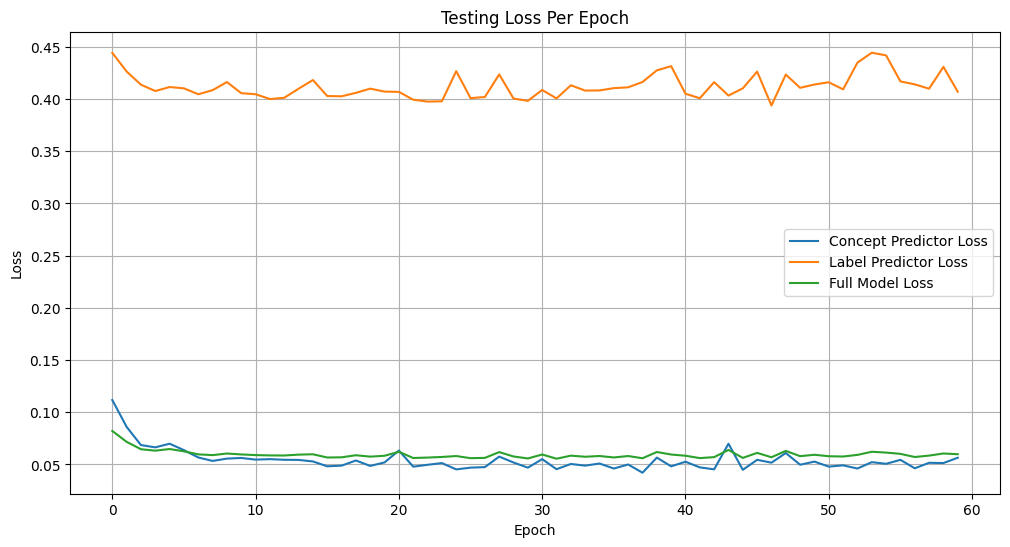

In [11]:
# Testing loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_val_loss_values, label='Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_val_loss_values, label='Label Predictor Loss')
plt.plot(epochs_count, total_val_loss_values, label='Full Model Loss')
plt.title('Testing Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Validation Evaluation

In [12]:
# Concept Predictor Evaluation
def evaluate_concept_predictor(ground_truth_c, x_to_c_predictions, concept_labels):
    results = []
    for i, label in enumerate(concept_labels):
        true_values = np.concatenate([c[:, i].numpy() for c in ground_truth_c])
        predicted_values = np.concatenate([c[:, i] for c in x_to_c_predictions])

        predicted_classes = (predicted_values > 0.5).astype(int)  # Convert probabilities to binary classes

        precision = precision_score(true_values, predicted_classes, zero_division=0)
        recall = recall_score(true_values, predicted_classes, zero_division=0)
        f1 = f1_score(true_values, predicted_classes, zero_division=0)
        accuracy = accuracy_score(true_values, predicted_classes)

        results.append({
            "Label": label,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Accuracy": accuracy
        })
    return pd.DataFrame(results)

In [13]:
# Get concept labels from the data processor
concept_labels = data_processor.get_concepts()

# Evaluation
concept_predictor_results = evaluate_concept_predictor(ground_truth_val_c, x_to_c_val_predictions, concept_labels)
print("Validation Concept Predictor Results:")
print(concept_predictor_results)

Validation Concept Predictor Results:
                  Label  Precision    Recall  F1 Score  Accuracy
0     rsp_fail_moderate   0.867479  0.832990  0.849885  0.946518
1       rsp_fail_severe   0.562476  0.380362  0.453831  0.970556
2     cgn_fail_moderate   0.955166  0.953958  0.954562  0.970157
3       cgn_fail_severe   0.304892  0.203030  0.243747  0.993090
4     lvr_fail_moderate   0.917771  0.903873  0.910769  0.983088
5       lvr_fail_severe   0.883158  0.799048  0.839000  0.997324
6     cdv_fail_moderate   0.979127  0.974019  0.976566  0.967240
7       cdv_fail_severe   0.903691  0.876190  0.889728  0.987871
8     gcs_fail_moderate   0.977922  0.981924  0.979919  0.986595
9       gcs_fail_severe   0.861833  0.833211  0.847280  0.989816
10    rfl_fail_moderate   0.873557  0.882160  0.877837  0.931318
11      rfl_fail_severe   0.717893  0.672109  0.694247  0.971071
12                  SSH   0.871387  0.836213  0.853437  0.978447
13                  ARD   0.584322  0.443989  0.5045

In [14]:
# Label Predictor Evaluation
def evaluate_label_predictor(ground_truth_y, c_to_y_predictions):
    # Ensure all elements are tensors
    ground_truth_y = [torch.tensor(gy) if not isinstance(gy, torch.Tensor) else gy for gy in ground_truth_y]
    c_to_y_predictions = [torch.tensor(py) if not isinstance(py, torch.Tensor) else py for py in c_to_y_predictions]

    true_values = torch.cat(ground_truth_y).numpy()
    predicted_values = torch.cat(c_to_y_predictions).squeeze().numpy()

    predicted_classes = (predicted_values > 0.5).astype(int)  # Convert probabilities to binary classes

    precision = precision_score(true_values, predicted_classes)
    recall = recall_score(true_values, predicted_classes)
    f1 = f1_score(true_values, predicted_classes)
    auc = roc_auc_score(true_values, predicted_classes)
    accuracy = accuracy_score(true_values, predicted_classes)

    results = {"Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy}

    index = pd.Index(["Metrics"])
    return pd.DataFrame(results, index=index)

In [15]:
# Evaluation
print("Validation Label Predictor Results:")
label_predictor_results = evaluate_label_predictor(ground_truth_val_y, c_to_y_val_predictions)
print(label_predictor_results)

Validation Label Predictor Results:
         Precision    Recall  F1 Score       AUC  Accuracy
Metrics   0.701707  0.311726  0.431682  0.639019  0.833633


# Testing Evaluation

In [16]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification

    running_x_to_c_test_loss, running_c_to_y_test_loss = 0.0, 0.0
    running_total_test_loss = 0.0
    total_test_samples = 0
    ground_truth_test_c, ground_truth_test_y = [], []
    x_to_c_test_predictions, c_to_y_test_predictions = [], []

    with torch.no_grad():
        for x, c, y in test_loader:
            # GPU
            x, c, y = x.to(device), c.to(device), y.to(device)

            # Ground truth array
            ground_truth_test_c.append(c.cpu())
            ground_truth_test_y.append(y.cpu())

            # Forward pass through the model
            x = x.to(model.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
            predicted_c, predicted_y = model(x)

            # Squeeze the predictions to match the target dimensions
            predicted_c = predicted_c.squeeze()
            predicted_y = predicted_y.squeeze()

            x_to_c_test_predictions.append(predicted_c.detach().cpu().numpy())
            c_to_y_test_predictions.append(predicted_y.detach().cpu().numpy())

            c_loss = criterion(predicted_c, c.float())
            y_loss = criterion(predicted_y, y.float())

            total_loss = c_loss + y_loss

            # Accumulate loss values for testing
            running_x_to_c_test_loss += c_loss.item()
            running_c_to_y_test_loss += y_loss.item()
            running_total_test_loss += total_loss.item()

            total_test_samples += len(y)

    print(f'Test Concept Predictor Loss: {running_x_to_c_test_loss / len(test_loader):.4f}')
    print(f'Test Label Predictor Loss: {running_c_to_y_test_loss / len(test_loader):.4f}')
    print(f'Test Total Loss: {running_total_test_loss / len(test_loader):.4f}')

    return ground_truth_test_c, ground_truth_test_y, x_to_c_test_predictions, c_to_y_test_predictions


In [17]:
# Call the test function and print the results
ground_truth_test_c, ground_truth_test_y, x_to_c_test_predictions, c_to_y_test_predictions = test_model(x_to_y, test_loader)

Test Concept Predictor Loss: 0.0533
Test Label Predictor Loss: 0.4216
Test Total Loss: 0.4749


In [18]:
# Evaluate and print test results for the concept predictor
concept_test_results = evaluate_concept_predictor(ground_truth_test_c, x_to_c_test_predictions, concept_labels)
print("Test Concept Predictor Results:")
print(concept_test_results)

Test Concept Predictor Results:
                  Label  Precision    Recall  F1 Score  Accuracy
0     rsp_fail_moderate   0.916918  0.833791  0.873381  0.956121
1       rsp_fail_severe   0.513889  0.587302  0.548148  0.969584
2     cgn_fail_moderate   0.944000  0.981846  0.962551  0.974819
3       cgn_fail_severe   0.444444  0.275862  0.340426  0.992271
4     lvr_fail_moderate   0.909756  0.907543  0.908648  0.981301
5       lvr_fail_severe   0.677419  0.777778  0.724138  0.996011
6     cdv_fail_moderate   0.980159  0.986207  0.983174  0.976814
7       cdv_fail_severe   0.902985  0.941634  0.921905  0.989778
8     gcs_fail_moderate   0.986360  0.980728  0.983536  0.988532
9       gcs_fail_severe   0.828358  0.804348  0.816176  0.987534
10    rfl_fail_moderate   0.925764  0.919341  0.922541  0.955622
11      rfl_fail_severe   0.764368  0.630332  0.690909  0.970332
12                  SSH   0.910299  0.837920  0.872611  0.980055
13                  ARD   0.505495  0.666667  0.575000  0.

In [19]:
# Evaluate and print test results for the label predictor
label_test_results = evaluate_label_predictor(ground_truth_test_y, c_to_y_test_predictions)
print("Test Label Predictor Results:")
print(label_test_results)

Test Label Predictor Results:
         Precision    Recall  F1 Score       AUC  Accuracy
Metrics   0.700483  0.328426  0.447186  0.644392  0.821242
